# Lesson 4: Creating an MCP Server

In this lesson, you will wrap the tools of the chatbot of the previous lesson, to build an MCP server that exposes 2 tools. You will use here the `stdio` transport and run the server in the provided local environment. You will learn more about remote servers in another lesson.

## How can you create an MCP Server? - *Additional Note*

Let's take the example of a server that exposes tools. This server needs to handle two main requests from the client:
- listing all the tools
  
   <img src="images/server_list_tools.png" width="400">

- executing a particular tool
  
  <img src="images/server_call_tool.png" width="400">

There are two ways for creating an MCP server:
- **low-level implementation**: in this approach, you directly define and handle the various types of requests (`ListToolsRequest` and `CallToolRequest`). This approach allows you to customize every aspect of your server.
- **high-level implementation using `FastMCP`**: `FastMCP` is a high-level interface that makes building MCP servers faster and simpler. In this approach, you just focus on defining the tools as functions, and`FastMCP` handles all the protocol details.
  
You will use in this lesson `FastMCP`. If you'd like to learn more about the low-level approach, you can check out the resources at the end of this notebook.

## Building your MCP Server using `FastMCP`

You will build the files needed for your MCP server in the folder `mcp_project`. You will incrementally add or update more files to this project folder in the upcoming lessons. The `mcp_project` folder is provided to you. You will first create the python file of the server `research_server.py` and save it in  `mcp_project` folder, then you'll prepare the environment to run the server.

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b> To Access the  <code>mcp_project</code> folder :</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em> and finally 3) click on <em>L4</em>.
</div>

To create your MCP server using `FastMCP`, you will initialize a `FastMCP` server labeled as `mcp` and decorating the functions with `@mcp.tool()`. `FastMCP` automatically generates the necessary MCP schema based on type hints and docstrings.


**Note**: The magic function `%%writefile mcp_project/research_server.py` will not execute the code but it will save the content of the cell to the server file `research_server.py` in the directory: `mcp_project`. If you remove the magic function and run the cell, the code won't run in Jupyter notebook. You will run the server from the terminal in the next section. 

In [1]:
%%writefile mcp_project/research_server.py

import arxiv
import json
import os
from typing import List
from mcp.server.fastmcp import FastMCP


PAPER_DIR = "papers"

# Initialize FastMCP server
mcp = FastMCP("research")

@mcp.tool()
def search_papers(topic: str, max_results: int = 5) -> List[str]:
    """
    Search for papers on arXiv based on a topic and store their information.
    
    Args:
        topic: The topic to search for
        max_results: Maximum number of results to retrieve (default: 5)
        
    Returns:
        List of paper IDs found in the search
    """
    
    # Use arxiv to find the papers 
    client = arxiv.Client()

    # Search for the most relevant articles matching the queried topic
    search = arxiv.Search(
        query = topic,
        max_results = max_results,
        sort_by = arxiv.SortCriterion.Relevance
    )

    papers = client.results(search)
    
    # Create directory for this topic
    path = os.path.join(PAPER_DIR, topic.lower().replace(" ", "_"))
    os.makedirs(path, exist_ok=True)
    
    file_path = os.path.join(path, "papers_info.json")

    # Try to load existing papers info
    try:
        with open(file_path, "r") as json_file:
            papers_info = json.load(json_file)
    except (FileNotFoundError, json.JSONDecodeError):
        papers_info = {}

    # Process each paper and add to papers_info  
    paper_ids = []
    for paper in papers:
        paper_ids.append(paper.get_short_id())
        paper_info = {
            'title': paper.title,
            'authors': [author.name for author in paper.authors],
            'summary': paper.summary,
            'pdf_url': paper.pdf_url,
            'published': str(paper.published.date())
        }
        papers_info[paper.get_short_id()] = paper_info
    
    # Save updated papers_info to json file
    with open(file_path, "w") as json_file:
        json.dump(papers_info, json_file, indent=2)
    
    print(f"Results are saved in: {file_path}")
    
    return paper_ids

@mcp.tool()
def extract_info(paper_id: str) -> str:
    """
    Search for information about a specific paper across all topic directories.
    
    Args:
        paper_id: The ID of the paper to look for
        
    Returns:
        JSON string with paper information if found, error message if not found
    """
 
    for item in os.listdir(PAPER_DIR):
        item_path = os.path.join(PAPER_DIR, item)
        if os.path.isdir(item_path):
            file_path = os.path.join(item_path, "papers_info.json")
            if os.path.isfile(file_path):
                try:
                    with open(file_path, "r") as json_file:
                        papers_info = json.load(json_file)
                        if paper_id in papers_info:
                            return json.dumps(papers_info[paper_id], indent=2)
                except (FileNotFoundError, json.JSONDecodeError) as e:
                    print(f"Error reading {file_path}: {str(e)}")
                    continue
    
    return f"There's no saved information related to paper {paper_id}."



if __name__ == "__main__":
    # Initialize and run the server
    mcp.run(transport='stdio')

Overwriting mcp_project/research_server.py


## Setting up your Environment & Testing your Server

You'll now set up the environment that you will use to run and test the server. For that, you will use the `uv` tool, which helps you manage your Python environment: it automatically sets up the project files and manages the package dependencies.

**Terminal Instructions**

- To open the terminal, run the cell below.
- Navigate to the project directory and initiate it with `uv`:
    - `cd L4/mcp_project`
    - `uv init`
-  Create virtual environment and activate it:
    - `uv venv`
    - `source .venv/bin/activate`
- Install dependencies:
    - `uv add mcp arxiv`
- Launch the inspector:
    - `npx @modelcontextprotocol/inspector uv run research_server.py`
    - If you get a message asking "need to install the following packages", type: `y`
- You will get a message saying that the inspector is up and running at a specific address. To open the inspector, click on that given address. The inspector will open in another tab.
- In the inspector UI, make sure to follow the video. You would need to specify under configuration the `Inspector Proxy Address`. Please check the "Inspector UI Instructions" below and run the last cell (after the terminal) to get the `Inspector Proxy Address` for your configurations. 
- If you tested the tool and would like to access the `papers` folder: 1) click on the `File` option on the top menu of the notebook and 2) click on `Open` and then 3) click on `L4` -> `mcp_project`.
- Once you're done with the inspector UI, make sure to close the inspector by typing `Ctrl+C` in the terminal below.

In [2]:
# start a new terminal
import os
from IPython.display import IFrame

IFrame(
    f"{os.environ.get('DLAI_LOCAL_URL').format(port=8888)}terminals/1",
    width=600,
    height=768,
)

### Inspector UI Instructions

In the inspector UI, make sure you have:

<img src="images/inspector2.png" height="300">

1.  `uv` under command
2.  `run research_server.py` under arguments
3.  Under configuration, you have to specify the "Inspector Proxy Address":
      - Run the following cell and copy the output address and paste it under "Inspector Proxy Address" in the inspector UI. **Note**: if you're running the inspector locally on your machine, you don't need to worry about this step.

In [3]:
# Print the inspector proxy address
print(
    "Inspector Proxy Address that you need to specify under configuration in the inspector UI:"
)
print(os.environ.get("DLAI_LOCAL_URL").format(port=6277)[:-1])

Inspector Proxy Address that you need to specify under configuration in the inspector UI:
https://s172-29-61-100p6277.lab-aws-production.deeplearning.ai


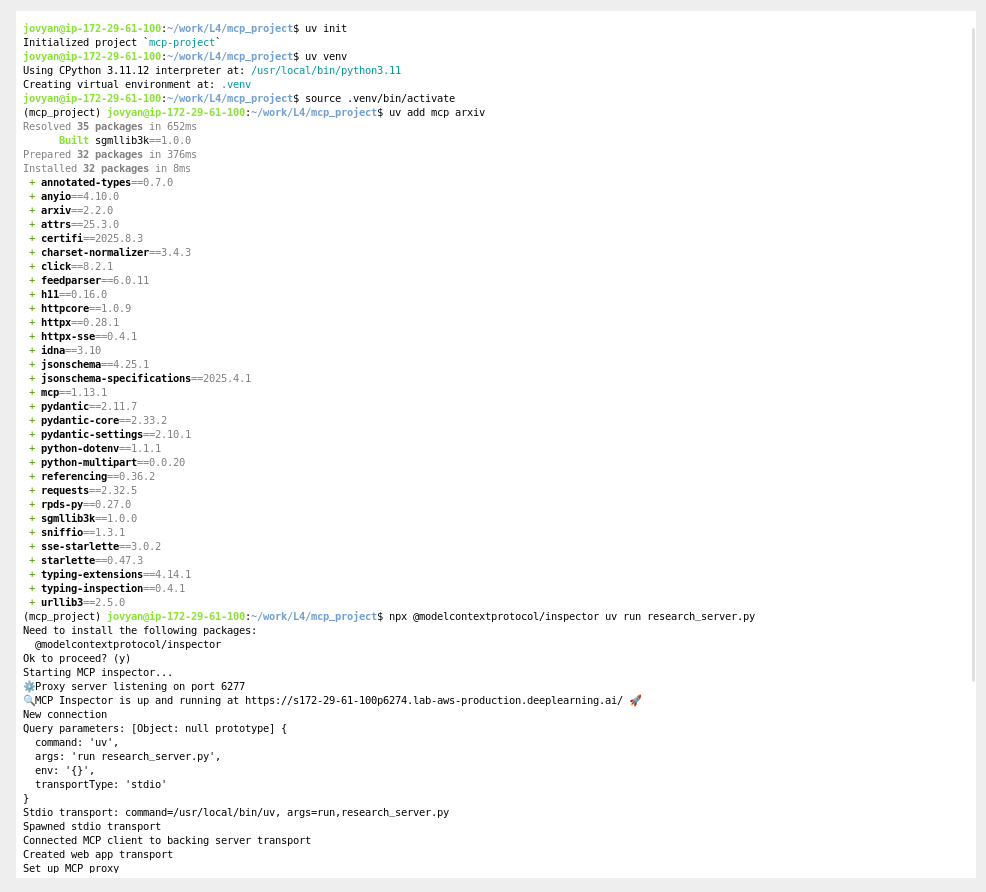

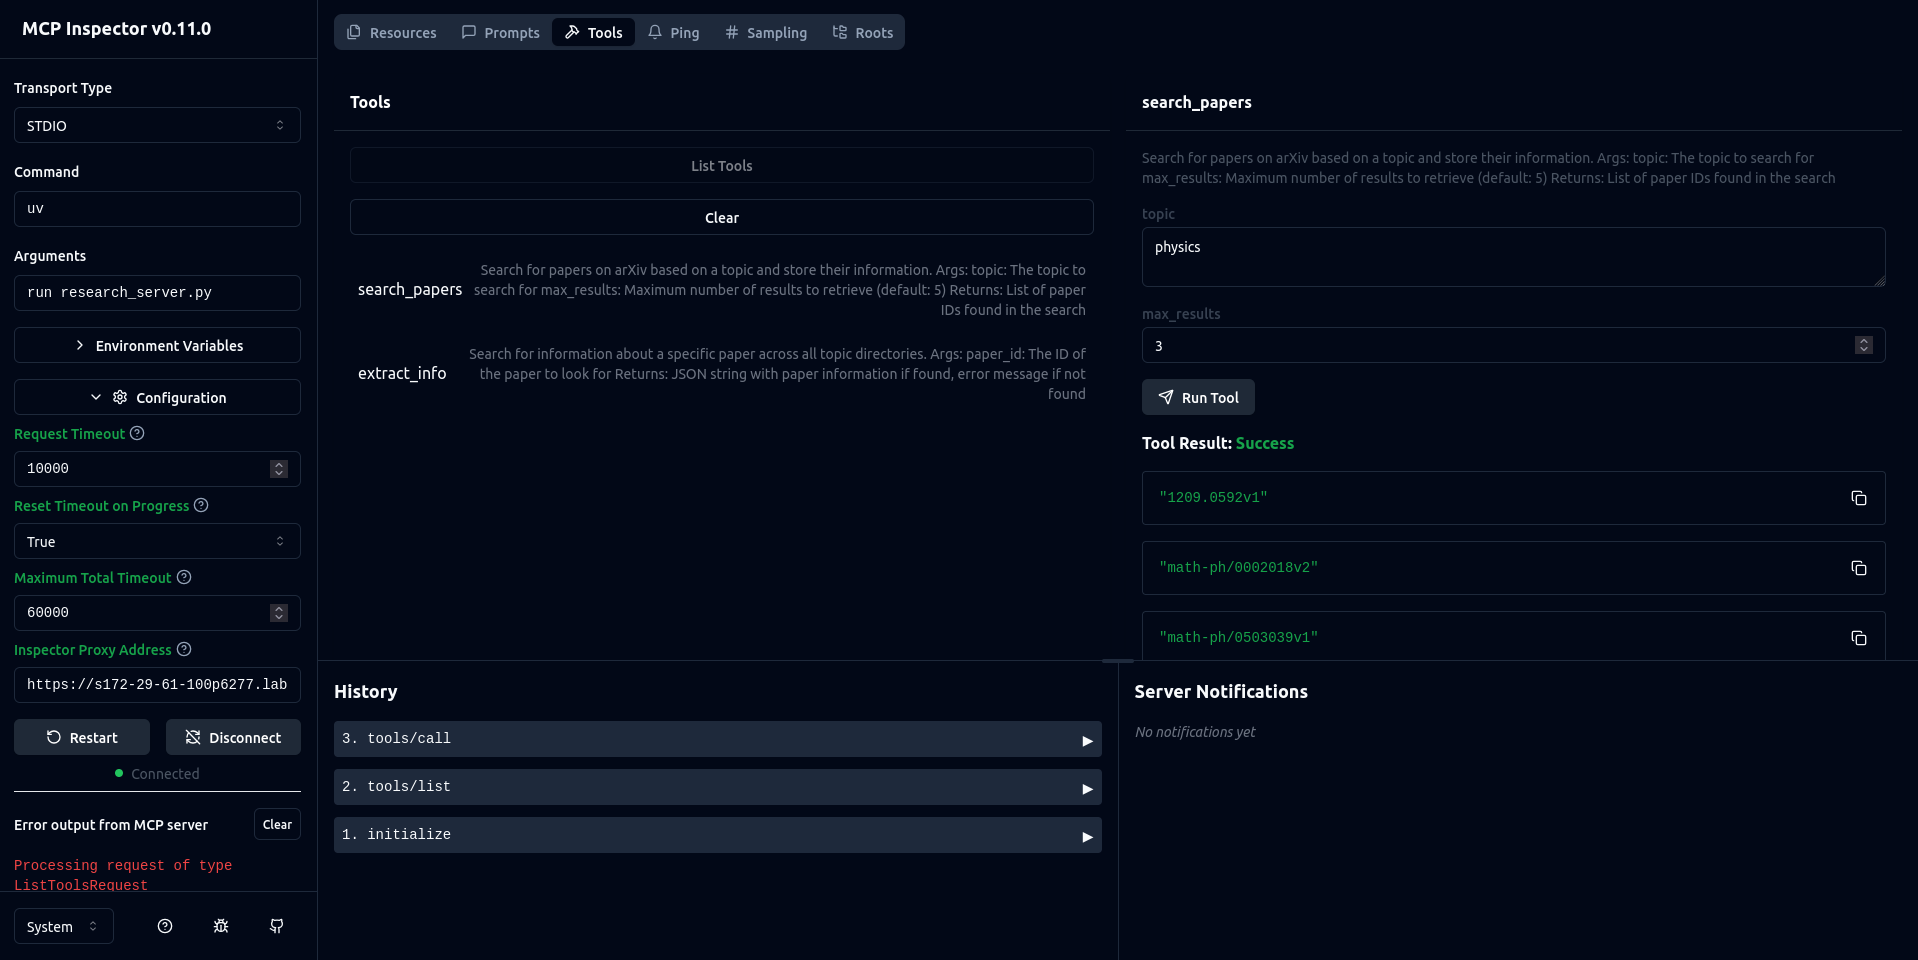

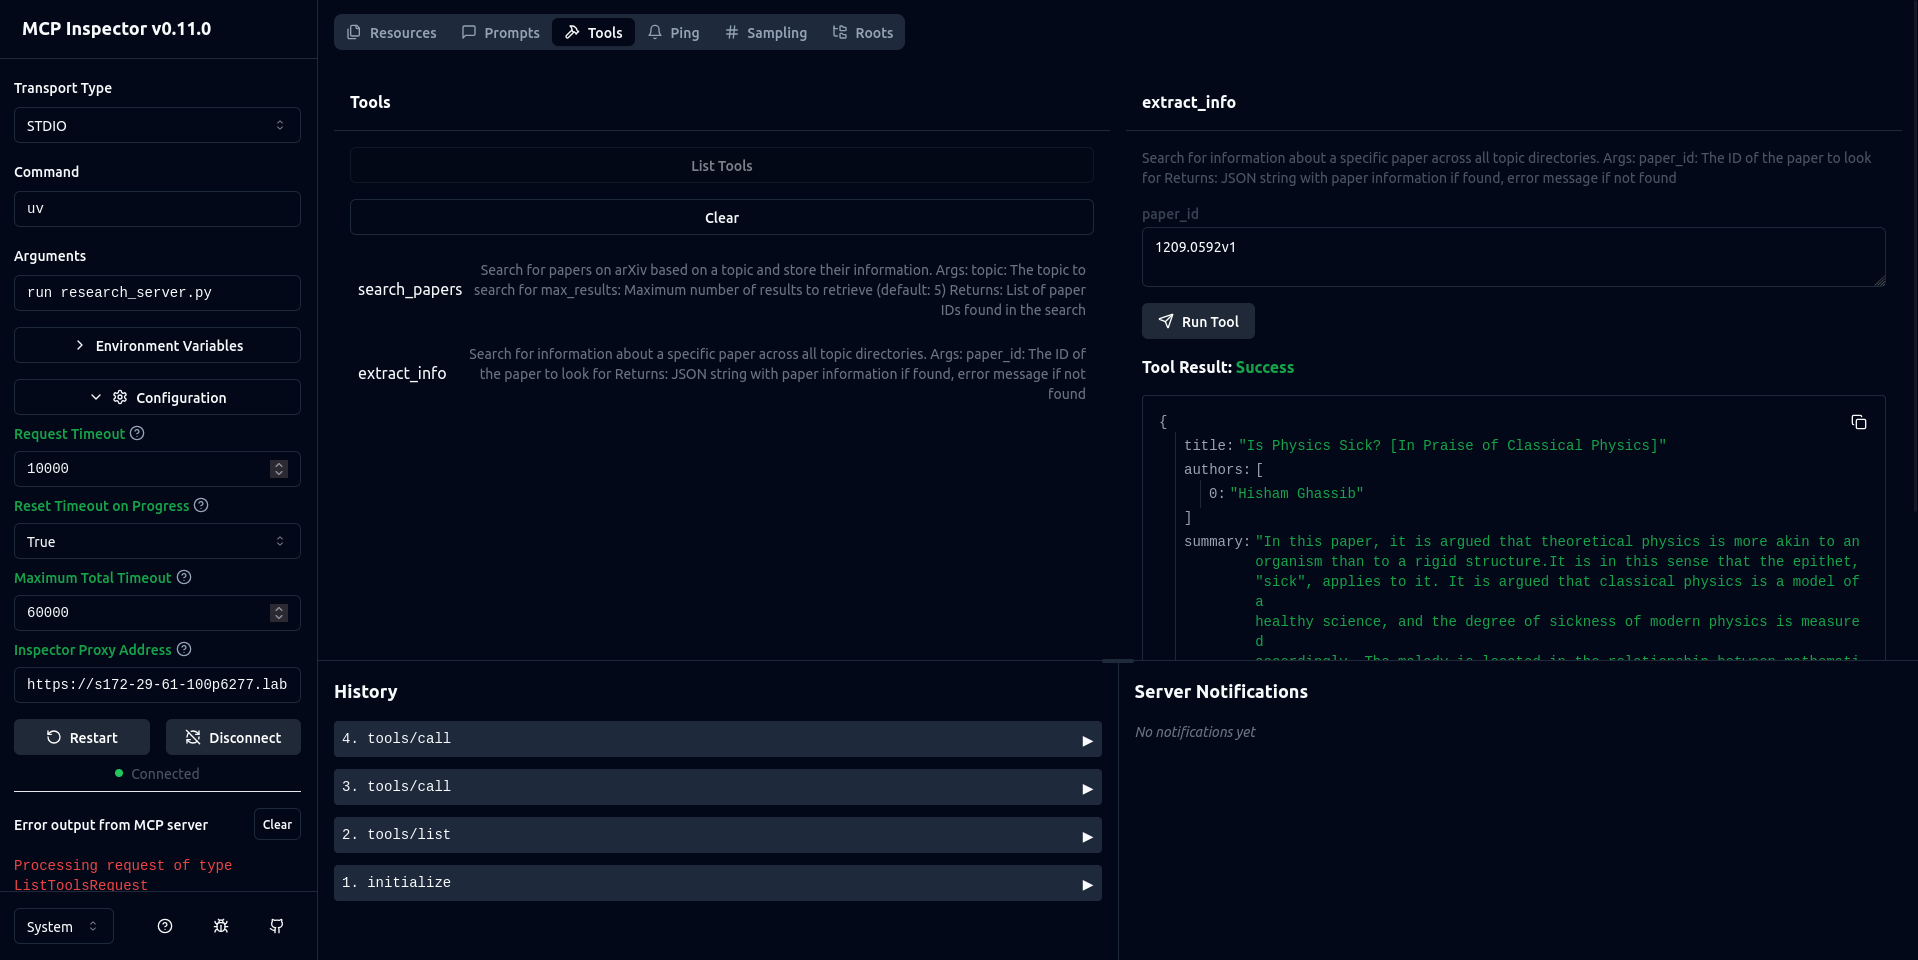

In [4]:
f"{os.environ.get('DLAI_LOCAL_URL').format(port=8888)}terminals/1"

'https://s172-29-61-100p8888.lab-aws-production.deeplearning.ai/terminals/1'

## Resources

- [Example of low-level server](https://github.com/modelcontextprotocol/python-sdk/blob/main/examples/servers/simple-tool/mcp_simple_tool/server.py)
- [Advanced usage low-level server](https://github.com/modelcontextprotocol/python-sdk/blob/main/README.md#advanced-usage)
- [MCP inspector](https://github.com/modelcontextprotocol/inspector)
- [FastMCP](https://github.com/jlowin/fastmcp)
- [Quickstart for server developpers](https://modelcontextprotocol.io/quickstart/server)

### How to replicate the work locally?

- First make sure you have `uv` installed. You can check the installation methods [here](https://docs.astral.sh/uv/getting-started/installation/#pypi).
- Second you need to make sure you have `Node.js` installed on your machine. This is needed to run packages written in  `Typescript` (like the MCP inspector and maybe other MCP servers that you may download to use in your app). For instructions, check [here](https://docs.npmjs.com/downloading-and-installing-node-js-and-npm)

After you have these two installed, then you can create the `mcp_project` folder and follow the same steps. If you're using a `Windows` machine, the only step you need to modify is how to activate your virtual environment. Instead of `source .venv/bin/activate`, you would need to type: `.venv\Scripts\activate` without `source`.

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b> To Access the  <code>mcp_project</code> folder :</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.
<p> ⬇ &nbsp; <b>To Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>